## LEGENDA 'Conservation Status'
Least Concern (LC): Indica che una specie non è attualmente a rischio di estinzione. Queste specie sono considerate relativamente sicure in natura.

Vulnerable (VU): Indica che una specie è a rischio di estinzione in natura, ma non è ancora considerata in pericolo critico. Le specie vulnerabili potrebbero avere una popolazione ridotta o affrontare minacce significative nell'ambiente circostante.

Endangered (EN): Indica che una specie è a rischio di estinzione imminente in natura. Queste specie hanno una popolazione molto bassa e/o affrontano minacce gravi che mettono a rischio la loro sopravvivenza.

Not Evaluated (NE): Indica che lo stato di conservazione di una specie non è stato ancora valutato o non è disponibile alcuna informazione sulla sua popolazione o sulle minacce che affronta.

Near Threatened (NT): Indica che una specie non è ancora classificata come vulnerabile, ma potrebbe diventarlo in futuro se le minacce che affronta non vengono affrontate o se la popolazione continua a diminuire.

Critically Endangered (CR): Indica che una specie è in grave pericolo di estinzione in natura. Le specie classificate come criticamente in pericolo hanno una popolazione estremamente bassa e/o affrontano minacce estreme che mettono a rischio la loro sopravvivenza nel breve termine.

Varies: Indica che lo stato di conservazione di una specie varia, a seconda delle diverse popolazioni o sotto-specie che possono essere classificate in modi diversi.

Data Deficient (DD): Indica che non ci sono dati sufficienti per valutare lo stato di conservazione di una specie. Questo può essere dovuto alla mancanza di informazioni sulla popolazione, sulle minacce o sulla distribuzione della specie.

In [259]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import inflect
from networkx.algorithms import cluster, community
import itertools
import matplotlib.pyplot as plt
import powerlaw 

df = pd.DataFrame(pd.read_csv('datasetAnimali/Animal Dataset.csv'))
df['index'] = df.index
df

,Animal,Height (cm),Weight (kg),Color,Lifespan (years),Diet,Habitat,Predators,Average Speed (km/h),Countries Found,Conservation Status,Family,Gestation Period (days),Top Speed (km/h),Social Structure,Offspring per Birth,index
0,Aardvark,105-130,40-65,Grey,20-30,Insectivore,"Savannas, Grasslands","Lions, Hyenas",40,Africa,Least Concern,Orycteropodidae,210-240,40,Solitary,1,0
1,Aardwolf,40-50,8-14,Yellow-brown,10-12,Insectivore,"Grasslands, Savannas","Lions, Leopards",24-30,Eastern and Southern Africa,Least Concern,Hyaenidae,90,40,Solitary,2-5,1
2,African Elephant,270-310,2700-6000,Grey,60-70,Herbivore,"Savannah, Forest","Lions, Hyenas",25,Africa,Vulnerable,Elephantidae,640-660,40,Herd-based,1,2
3,African Lion,80-110,120-250,Tan,10-14,Carnivore,"Grasslands, Savannas","Hyenas, Crocodiles",58,Africa,Vulnerable,Felidae,98-105,80,Group-based,2-4 (usually),3
4,African Wild Dog,75-80,18-36,Multicolored,10-12,Carnivore,Savannahs,"Lions, Hyenas",56,Sub-Saharan Africa,Endangered,Canidae,70,56,Group-based,10-12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Yak,140-160,500-1200,"Brown, Black",20-25,Herbivore,Mountains,"Snow Leopards, Wolves",24,"Himalayas, Central Asia",Least Concern,Bovidae,215-280,24,Group-based,10-50,200
201,Yellow-Eyed Penguin,60-65,1-3,"Yellow, White",Up to 20,Carnivore,Coastal Areas,"Seals, Orcas",25,New Zealand,Endangered,Spheniscidae,80-90,25,Solitary,1,201
202,Yeti Crab,Up to 15,Up to 0.5,"White, Hairy",Up to 20,Omnivore,Hydrothermal Vents,Not Applicable,Not Applicable,Pacific Ocean,Not Evaluated,Kiwaidae,Not Applicable,Not Applicable,Solitary,Not Applicable,202
203,Zebra,220-340,400-900,"Black, White",20-25,Herbivore,Grasslands,"Lions, Hyenas",25,Africa,Least Concern,Equidae,180-365,25,Group-based,5-20,203


In [260]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [261]:
def uniqueValues(column_name):
    return df[column_name].unique()

def contaValoriUnici(dataset,colonna):
    for i in dataset[colonna].unique():
        print("Valore ",i,"counts: ",(dataset[colonna] ==i).sum())

def addPredators(nome_preda, arr_predators):
    for nome_predatore in arr_predators:
        df.loc[df['Animal'] == nome_preda, 'Predators'] = df.loc[df['Animal'] == nome_preda, 'Predators'] + ', ' + nome_predatore
        
def replacePreators(nome_preda, arr_predators):
    df.loc[df['Animal'] == nome_preda, 'Predators'] = arr_predators[0]
    for nome_predatore in arr_predators:
        if nome_predatore != arr_predators[0]:
            df.loc[df['Animal'] == nome_preda, 'Predators'] = df.loc[df['Animal'] == nome_preda, 'Predators'] + ', ' + nome_predatore

def plural_to_singular(plural_words):
    p = inflect.engine()
    singular_words = []
    for word in plural_words:
        singular_word = p.singular_noun(word)
        if singular_word:
            singular_words.append(singular_word)
        else:
            singular_words.append(word)
    return singular_words

def plural_to_singular_word(word):
    p = inflect.engine()
    singular = p.singular_noun(word)
    if singular:
        return singular
    else:
        return word
    
#stampa archi entranti e uscenti di un certo animale
def visualize_node_edges(G, node_name):
    if node_name in G.nodes():
        successors = list(G.successors(node_name))
        predecessors = list(G.predecessors(node_name))
        
        print(f"Gli archi uscenti dal nodo {node_name} sono:")
        for successor in successors:
            print(f"{node_name} -> {successor}")
        
        print(f"\nGli archi entranti nel nodo {node_name} sono:")
        for predecessor in predecessors:
            print(f"{predecessor} -> {node_name}")
    else:
        print(f"Il nodo {node_name} non esiste nel grafo.")

def transform_weight(weight_str):
    if "Up to" in weight_str:
        return float(re.findall(r'\d*\.?\d+', weight_str)[0])
    else:
        if weight_str == 'Varies':
            return -1
        min_weight, max_weight = map(float, re.findall(r'\d*\.?\d+', weight_str))
        return (min_weight + max_weight) / 2
    
def label_weight(weight):
    if weight == -1:
        return 'Not Applicable'
    elif weight < 30:
        return 'Small'
    elif 30 <= weight <= 60:
        return 'Medium'
    else:
        return 'Heavy'


In [262]:
#stampa i nodi che contengono una certa parola
def find_nodes_containing_keyword(G, keyword):
    matching_nodes = []
    for node in G.nodes():
        if keyword.lower() in node.lower():
            matching_nodes.append(node)
    return matching_nodes

# keyword = "orangutan"
# matching_nodes = find_nodes_containing_keyword(G, keyword)
# if matching_nodes:
#     print(f"I nodi che contengono la parola '{keyword}' nel loro nome sono:")
#     for node in matching_nodes:
#         print(node)
# else:
#     print(f"Nessun nodo trovato contenente la parola '{keyword}'.")


## Droppare animali estinti, i predatori Not Applicable e quelli che non hanno una area geografica

In [263]:
# Elimino gli animali duplicati nella colonna Animal
indici_righe_da_eliminare = [82, 85, 106, 110, 124, 131]
df.drop(indici_righe_da_eliminare, inplace=True)

In [264]:
addPredators('African Elephant', ['Crocodile'])
replacePreators('Alpine Ibex', ['Mountain Tigers','Wolves', 'Lynxes', 'Bears', 'Foxes'])
replacePreators('Amazon Rainforest Frog', ['leimadophis epinephelus'])
replacePreators('Arabian Oryx', ['Striped Hyenas', 'Arabian Wolves', 'Lions'])
replacePreators('Arctic Fox', ['Polar Bears', 'Wolves', 'Golden Eagles', 'Grizzly Bears', 'Bald Eagles'])
replacePreators('Asian Elephant', ['Tigers'])
replacePreators('Atlantic Puffin', ['Great Skua', 'Great Black-backed Gull', 'Foxes'])
addPredators('Aye-Aye', ['Fossas'])
addPredators('Baird\'s Tapir', ['Pumas'])
replacePreators('Bald Eagle', ['Owls', 'Raccoons', 'Wolverines', 'Crows', 'Hawks'])
addPredators('Banded Palm Civet', ['Owls', 'Snakes'])
addPredators('Barbary Macaque', ['Domestic Dogs'])
addPredators('Bearded Dragon', ['Foxes'])
replacePreators('Blue Jay', ['Hawks', 'Owls', 'Falcons', 'Snakes'])
addPredators('Blue-Footed Booby	', ['Galapagos Hawk'])
replacePreators('Bornean Orangutan', ['Leopards', 'Bearded Pigs', 'Crocodiles', 'Pythons', 'Black Eagles'])
replacePreators('Bottlenose Dolphin', ['Tiger Sharks', 'Dusky Sharks', 'Bull Sharks', 'Great White Sharks'])
replacePreators('Brown Bear', ['Wolves', 'Cougars'])
replacePreators('Burmese Python', ['Asian Tigers', 'Leopards'])
addPredators('Capybara', ['Caimans'])
addPredators('Cheetah', ['Leopards'])
replacePreators('Chinese Giant Salamander', ['Otters', 'Foxes', 'Weasels', 'Badgers'])
replacePreators('Common Snapping Turtle', ['Foxes', 'Coyotes', 'Skunks', 'Minks', 'Fishers', 'Raccoons', 'Crows', 'Herons', 'Hawks', 'Owls', 'Bullfrogs', 'Fish', 'Snakes'])
replacePreators('Dhole', ['Not Applicable'])
replacePreators('Dingo', ['Crocodiles', 'Canid Species'])
addPredators('Dugong', ['Saltwater Crocodiles'])
addPredators('Eastern Gorilla', ['Crocodiles'])
addPredators('Echidna', ['Feral Cats', 'Foxes', 'Goannas'])
addPredators('Emperor Penguin', ['Sea Lions', 'Orcas'])
addPredators('Emperor Tamarin', ['Wild Cats', 'Dogs', 'Snakes', 'Birds of Prey'])
addPredators('Fennec Fox', ['Large Mammals'])
replacePreators('Flying Fox', ['Eagles', 'Owls', 'Pythons'])
addPredators('Galápagos Penguin', ['Sea Lions', 'Snakes', 'Owls', 'Hawks'])
replacePreators('Galápagos Tortoise', ['Galápagos hawk'])
addPredators('Gaur', ['Dhole', 'Saltwater Crocodiles'])
addPredators('Gerenuk', ['African Wild Dogs', 'Cheetahs', 'Hyenas'])
addPredators('Giant Panda', ['Yellow-Throated Martens', 'Eagles', 'Feral Dogs', 'Asian Black Bear'])
addPredators('Gila Monster', ['Hawks', 'Owls', 'Snakes'])
addPredators('Golden Lion Tamarin', ['Wild Cats'])
addPredators('Green Anaconda', ['Crab-eating Foxes', 'Tegu Lizards', 'Crested Caracaras'])
addPredators('Grevy\'s Zebra', ['Leopards', 'Hunting Dogs', 'Cheetah'])
addPredators('Harp Seal', ['Large Sharks'])
replacePreators('Hummingbird', ['Owls', 'Grackles', 'Blue Jays', 'Herons', 'Tanagers', 'Loggerhead Shrikes', 'Gulls'])
replacePreators('Japanese Macaque', ['Mountain Hawk Eagles', 'Feral Dogs', 'Raccoon Dogs'])
replacePreators('Kangaroo Rat', ['Swift Foxes', 'Badgers', 'Bobcats',  'Coyotes', 'Snakes', 'Rattlesnakes', 'Raptors', 'Owls'])
replacePreators('King Cobra', ['Birds', 'Mongooses'])
addPredators('Lemur', ['Boas'])
addPredators('Lion-tailed Macaque', ['Snakes', 'Raptors'])
addPredators('Lyrebird', ['Quolls', 'Dogs', 'Feral Cats', 'Foxes'])
addPredators('Mandrill', ['African Rock Pythons', 'Crowned Eagles'])
replacePreators('Markhor', ['Eurasian Lynxs', 'Snow Leopards','Himalayan Wolfes', 'Brown Beas'])
addPredators('Meerkat', ['Snakes'])
replacePreators('Okapi', ['Leopards', 'Servals', 'Golden Cats'])
addPredators('Orangutan', ['Large Pythons'])
addPredators('Pangolin', ['Leopards', 'Hyenas', 'Pythons'])
addPredators('Patagonian Mara', ['Felids', 'Grisons'])
replacePreators('Pink Fairy Armadillo', ['Foxes', 'Birds of Prey', 'Birds', 'Canids'])
replacePreators('Platypus', ['Snakes', 'Water Rats', 'Goannas', 'Foxes', 'Cats', 'Dogs'])
replacePreators('Praying Mantis', ['Frogs', 'Lizards', 'Spiders', 'Hornets', 'Ants', 'Birds', 'Bats'])
addPredators('Proboscis Monkey', ['Crocodiles', 'Pythons'])
replacePreators('Pronghorn', ['Wolves', 'Foxes', 'Coyotes', 'Bobcats', 'Golden Eagles'])
replacePreators('Rottweiler', ['Not Applicable'])
addPredators('Serval', ['Wild Dogs'])
replacePreators('Shoebill', ['Crocodiles'])
replacePreators('Siberian Husky', ['Not Applicable'])
addPredators('Sloth', ['Ocelots'])
addPredators('Slow Loris', ['Orangutans', 'Hawk Eagles'])
replacePreators('Snow Leopard', ['Humans'])
replacePreators('Spider Monkey', ['Jaguars', 'Eagles', 'Snakes'])
replacePreators('Spotted Hyena', ['Lions'])
replacePreators('Star-Nosed Mole', ['Raptors', 'Screech', 'Great Horned', 'Long-Eared', 'Barred', 'Barn Owls', 'Red-Tailed Hawks'])
addPredators('Sumatran Orangutan', ['Clouded Leopards', 'Large Pythons', 'Crocodiles'])
addPredators('Tarsier', ['Monitor Lizards', 'Raptors'])
replacePreators('Termite', ['Echidnas', 'Foxes', 'Galagos', 'Numbats', 'Mongooses', 'Mice', 'Pangolins', 'Genets', 'Civits', 'Bats', 'Echidnas', 'Moles', 'Shrews', 'Bibbies'])
addPredators('Three-Toed Sloth', ['Ocelots', 'Jaguars'])
replacePreators('Toco Toucan', ['Forest Eagles', 'Hawks', 'Owls', 'Boas', 'Jaguars', 'Margays'])
addPredators('Tuatara', ['Birds of Pray'])
replacePreators('Tufted Puffin', ['Bald Eagles', 'Peregrine Falcons', 'Snowy Owls', 'Eagle Owls', 'Sharks', 'Artic foxes', 'Red Foxes'])
addPredators('Uakari', ['Birds of Pray'])
addPredators('Vampire Bat', ['Eagles'])
addPredators('Vaquita', ['Orcas'])
replacePreators('Vulture', ['Hawks', 'Snakes', 'Wild Cats'])
addPredators('Warthog', ['Spotted Hyenas', 'Cheetahs', 'African Wild Dogs'])
addPredators('Water Buffalo', ['Lions'])
replacePreators('Wild Boar', ['Wolves'])
addPredators('Wildebeest', ['Hyenas', 'Cheetahs', 'Wild Dogs'])
addPredators('Wolverine', ['Mountain Lions'])
replacePreators('Wombat', ['Foxes', 'Dingoes', 'Wild Dogs', 'Eagles', 'Tasmanian Devils'])
addPredators('Woodpecker', ['Feral Cats', 'Foxes', 'Hawks', 'Coyotes'])
addPredators('Yellow-Eyed Penguin', ['Cats', 'Stoats', 'Dogs', 'Ferrets', 'Barracoota', 'Sharks', 'Sea Lions'])
addPredators('Zebra', ['Wild dogs', 'Cheetahs'])

In [265]:
df.Predators.unique()
df = df.rename(columns={'Predators': 'AllPredators'})

In [266]:
# Droppo animali estinti
df = df.loc[(df['Conservation Status'] != 'Extinct (around 4,000 years ago)') &
             (df['Conservation Status'] != 'Extinct (around 58 million years ago)') &
               (df['Conservation Status'] != 'Extinct')]

# Deroppo gli animali che non hanno predatori e che non hanno uno stato di conservazione definito
df = df.loc[(df['AllPredators'] != 'Not Applicable') & (df['Conservation Status'] != 'Not Applicable')]

In [267]:
# Estraiamo gli animali e i predatori in un unico elenco
animals = df['Animal'].tolist()
predators = df['AllPredators'].str.split(', ').explode().unique().tolist()

In [268]:
animali_duplicati = df[df.duplicated(subset=['Animal'], keep=False)]
animali_duplicati

,Animal,Height (cm),Weight (kg),Color,Lifespan (years),Diet,Habitat,AllPredators,Average Speed (km/h),Countries Found,Conservation Status,Family,Gestation Period (days),Top Speed (km/h),Social Structure,Offspring per Birth,index


In [269]:
sing_predators = plural_to_singular(predators)

animali_comuni = set(sing_predators).intersection(set(animals))

In [270]:
G = nx.DiGraph()

# Aggiungere nodi al grafo con lo stato di conservazione, se presente
for animal in animals:
    status = df[df['Animal'] == animal]['Conservation Status'].iloc[0]
    height = df[df['Animal'] == animal]['Height (cm)'].iloc[0]
    weight = df[df['Animal'] == animal]['Weight (kg)'].iloc[0]
    lifespan = df[df['Animal'] == animal]['Lifespan (years)'].iloc[0]
    habitat = df[df['Animal'] == animal]['Habitat'].iloc[0]
    family = df[df['Animal'] == animal]['Family'].iloc[0]
    gestation_period = df[df['Animal'] == animal]['Gestation Period (days)'].iloc[0]
    offspring_per_birth = df[df['Animal'] == animal]['Offspring per Birth'].iloc[0]
    countries = df[df['Animal'] == animal]['Countries Found'].iloc[0]
    pray = 'Yes'
    if animal in animali_comuni:
        pray = 'Not Only'
    G.add_node(animal, conservation_status = status, pray = pray, height = height, weight = weight, lifespan = lifespan, habitat = habitat,
               family = family, gestation_period = gestation_period, offspring_per_birth = offspring_per_birth, countries = countries)

# Aggiungere nodi predatori al grafo solo se non sono presenti in animali_comuni
for predator in sing_predators:
    if predator not in animali_comuni:
        G.add_node(predator, conservation_status = 'Not Have', pray = 'No')

for _, row in df.iterrows():
    animal = row['Animal']

    for predator in row['AllPredators'].split(', '):
        sing_predator = plural_to_singular_word(predator)
        G.add_edge(sing_predator, animal)


In [271]:
df['Weight (kg)'] = df['Weight (kg)'].str.replace(',', '.')
df['Weight (kg)'] = df['Weight (kg)'].apply(transform_weight)

#Adesso voglio raggruppare gli animali in leggeri, medi, grandi
df['weight_labeled'] = df['Weight (kg)'].apply(label_weight)

## ANALISI STRUTTURA DELLA RETE

Betweenness centrality: Misura il numero di volte che un nodo si trova sul percorso più breve tra tutte le coppie di nodi nella rete. I nodi con betweenness elevato possono essere considerati "ponti" importanti tra le parti della rete --> utile per trovare gli animali che sono sia prede che predatori più rilevanti nel nostro dataset e che qundi potrebbero essere complici di un eventuale danno a catena indiretto

In [272]:
# Betweenness Centrality --> più il valore è alto più il nodo 
betweenness_centrality = nx.betweenness_centrality(G)

print("Betweenness Centrality:", betweenness_centrality)
max_bc_node = max(betweenness_centrality, key=betweenness_centrality.get)
max_bc_value = betweenness_centrality[max_bc_node]

Betweenness Centrality: {'Aardvark': 0.0, 'Aardwolf': 0.0, 'African Elephant': 0.0, 'African Lion': 0.0, 'African Wild Dog': 4.83736769799346e-06, 'Alpine Ibex': 0.0, 'Amazon Rainforest Frog': 0.0, 'American Bison': 0.0, 'Anteater': 0.0, 'Arabian Oryx': 0.0, 'Arctic Fox': 0.0, 'Arowana': 0.0, 'Asian Elephant': 0.0, 'Atlantic Puffin': 0.0, 'Atlantic Spotted Dolphin': 0.0, 'Australian Fur Seal': 0.0, 'Axolotl': 0.0, 'Aye-Aye': 0.0, "Baird's Tapir": 0.0, 'Bald Eagle': 0.00011932173655050535, 'Banded Palm Civet': 0.0, 'Barbary Macaque': 0.0, 'Basking Shark': 0.0, 'Bearded Dragon': 0.0, 'Bengal Fox': 0.0, 'Bengal Tiger': 0.0, 'Black Rhinoceros': 0.0, 'Blue Jay': 2.902420618796076e-05, 'Blue Morpho Butterfly': 0.0, 'Blue Whale': 0.0, 'Blue-Footed Booby': 0.0, 'Blue-Ringed Octopus': 0.0, 'Bonobo': 0.0, 'Bornean Orangutan': 0.0, 'Bottlenose Dolphin': 0.0, 'Brazilian Wandering Spider': 0.0, 'Brown Bear': 0.0, 'Burmese Python': 0.0, 'Capybara': 0.0, 'Cheetah': 2.41868384899673e-05, 'Chimpanzee':

In [273]:
# Trova i 10 nodi con i valori più alti di Betweenness Centrality
top_10_bc_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:10]

# Stampa i risultati
print("I 10 nodi con i valori più alti di Betweenness Centrality:")
for node in top_10_bc_nodes:
    print(node, ":", betweenness_centrality[node])


I 10 nodi con i valori più alti di Betweenness Centrality:
Wolf : 0.00021445663461104337
Tiger : 0.00015479576633579072
Bald Eagle : 0.00011932173655050535
Dingo : 9.67473539598692e-05
Fossa : 7.739788316789536e-05
Wolverine : 6.127332417458382e-05
Orangutan : 3.869894158394768e-05
Snow Leopard : 3.386157388595422e-05
Blue Jay : 2.902420618796076e-05
Cheetah : 2.41868384899673e-05


Il coefficiente di clustering di un grafo misura il grado in cui i nodi nel grafo tendono a formare cluster o raggruppamenti.

In [274]:
# Calcolo del clustering coefficient
clustering_coefficient = nx.average_clustering(G)
print("Clustering Coefficient:", clustering_coefficient)

Clustering Coefficient: 0.0251954859790211


Quando esegui il rilevamento delle comunità su questo grafo, l'algoritmo cercherà di identificare gruppi di animali che sono più fortemente connessi tra loro rispetto alle connessioni con il resto del grafo --> utile per ottenre dei sotto-gruppi fortemente relazionati tra di loro, il che potrebbe anche implicare animali che appartengono allo stesso habitat

In [275]:
# Rilevamento delle comunità utilizzando l'approccio della modularity maximization
communities = community.greedy_modularity_communities(G)

# Creazione di un dizionario per mappare ogni specie alla sua comunità
community_mapping = {}
for idx, com in enumerate(communities):
    for species in com:
        community_mapping[species] = idx

# Stampare le comunità identificate
print("Community Detection:")
for species, community_id in community_mapping.items():
    print(species, ":", community_id)


Community Detection:
Bengal Tiger : 0
Bonobo : 0
Aardwolf : 0
Orangutan : 0
Hippopotamus : 0
Chimpanzee : 0
Mountain Gorilla : 0
Wildebeest : 0
Gerenuk : 0
Sumatran Orangutan : 0
Okapi : 0
Aye-Aye : 0
Lion : 0
Wildcat : 0
White Rhinoceros : 0
Mandrill : 0
Spotted Hyena : 0
Western Lowland Gorilla : 0
Gharial : 0
African Elephant : 0
Saola : 0
Asian Tiger : 0
Warthog : 0
Sumatran Rhinoceros : 0
Hunting Dog : 0
Grevy's Zebra : 0
Golden Cat : 0
Western Gorilla : 0
Aardvark : 0
Zebra : 0
Komodo Dragon : 0
Crowned Eagle : 0
Clouded Leopard : 0
Sumatran Tiger : 0
Fossa : 0
Indri : 0
Crocodile : 0
Proboscis Monkey : 0
African Wild Dog : 0
Tiger : 0
Sun Bear : 0
Naked Mole Rat : 0
African Lion : 0
Coquerel's Sifaka : 0
Pangolin : 0
Hyena : 0
Serval : 0
African Rock Python : 0
Black Rhinoceros : 0
Water Buffalo : 0
Large Python : 0
White Tiger : 0
Sumatran Rhino : 0
Leopard : 0
Asian Elephant : 0
Wild Dog : 0
Burmese Python : 0
Eastern Gorilla : 0
Larger Predator : 0
Human : 0
Wild dog : 0
Chee

Identifico le sottoreti presenti nella mia rete globale --> Utile per identificare animali chiave con pochi predaotori

In [276]:
# Identificazione di sottoreti dense
weakly_connected_components = list(nx.weakly_connected_components(G))

# Creazione di sottografi per ciascuna componente connessa debole
subgraphs = [G.subgraph(component) for component in weakly_connected_components]

# Stampare le dimensioni delle sottoreti dense
print("Dimensioni delle sottoreti dense:")
for i, subgraph in enumerate(subgraphs):
    print("Sottorete", i+1, ":", subgraph)


Dimensioni delle sottoreti dense:
Sottorete 1 : DiGraph with 313 nodes and 500 edges
Sottorete 2 : DiGraph with 2 nodes and 1 edges
Sottorete 3 : DiGraph with 2 nodes and 1 edges
Sottorete 4 : DiGraph with 2 nodes and 1 edges
Sottorete 5 : DiGraph with 2 nodes and 1 edges
Sottorete 6 : DiGraph with 2 nodes and 1 edges


In [277]:
def getSubNetNodes(sub_net_nodes):
    # Lista per memorizzare i nodi delle sottoreti dalla 2 alla 7
    nodes_in_subnet = []
    i = sub_net_nodes - 1
    # Itera attraverso i sottografi dalla 2 alla 7
    for subgraph in subgraphs[i:sub_net_nodes]:  # Partendo dall'indice 1 per selezionare il secondo sottografo
        # Aggiungi i nodi del sottografo corrente alla lista
        nodes_in_subnet.extend(subgraph.nodes())

    # Rimuovi i duplicati, se presenti
    nodes_in_subnet = list(set(nodes_in_subnet))

    # Stampa i nodi delle sottoreti dalla 2 alla 7
    print("Nodi nella sottorete:", nodes_in_subnet)

    #return nodes_in_subnet


In [278]:
getSubNetNodes(2)
getSubNetNodes(3)
getSubNetNodes(4)
getSubNetNodes(5)
getSubNetNodes(6)
getSubNetNodes(7)

Nodi nella sottorete: ['Amazon Rainforest Frog', 'leimadophis epinephelu']
Nodi nella sottorete: ['Galápagos hawk', 'Galápagos Tortoise']
Nodi nella sottorete: ['Galliformes', 'Vary']
Nodi nella sottorete: ['Various Predator', 'Hagfish']
Nodi nella sottorete: ['Larger Shark', 'Shortfin Mako Shark']
Nodi nella sottorete: []


In [279]:
# Rilevamento delle comunità utilizzando l'approccio della modularity maximization
communities = community.greedy_modularity_communities(G)

# Calcolo della betweenness centrality
betweenness = nx.betweenness_centrality(G)

# Creazione di un dizionario per mappare ogni specie alla sua comunità e alla sua betweenness centrality
node_attributes = {}
for idx, com in enumerate(communities):
    for species in com:
        node_attributes[species] = {'community': idx, 'betweenness_centrality': betweenness[species]}

# Aggiunta dei valori delle comunità e della betweenness centrality come attributi ai nodi del grafo
nx.set_node_attributes(G, node_attributes)

# Stampare le informazioni identificate per ogni nodo
print("Node Information:")
for node, data in G.nodes(data=True):
    print("Node:", node, "Community:", data['community'], "Betweenness Centrality:", data['betweenness_centrality'])


Node Information:
Node: Aardvark Community: 0 Betweenness Centrality: 0.0
Node: Aardwolf Community: 0 Betweenness Centrality: 0.0
Node: African Elephant Community: 0 Betweenness Centrality: 0.0
Node: African Lion Community: 0 Betweenness Centrality: 0.0
Node: African Wild Dog Community: 0 Betweenness Centrality: 4.83736769799346e-06
Node: Alpine Ibex Community: 1 Betweenness Centrality: 0.0
Node: Amazon Rainforest Frog Community: 14 Betweenness Centrality: 0.0
Node: American Bison Community: 1 Betweenness Centrality: 0.0
Node: Anteater Community: 4 Betweenness Centrality: 0.0
Node: Arabian Oryx Community: 12 Betweenness Centrality: 0.0
Node: Arctic Fox Community: 1 Betweenness Centrality: 0.0
Node: Arowana Community: 9 Betweenness Centrality: 0.0
Node: Asian Elephant Community: 0 Betweenness Centrality: 0.0
Node: Atlantic Puffin Community: 1 Betweenness Centrality: 0.0
Node: Atlantic Spotted Dolphin Community: 3 Betweenness Centrality: 0.0
Node: Australian Fur Seal Community: 3 Between

In [280]:
def jaccard_similarity_by_community(nome_feature):
    # Dizionario per mappare ogni comunità ai suoi stati di conservazione
    community_conservation_status = {}

    # Riempire il dizionario community_conservation_status con gli stati di conservazione di ogni comunità
    for species, community_id in community_mapping.items():
        conservation_status = df.loc[df['Animal'] == species, nome_feature].values
        if len(conservation_status) > 0:
            conservation_status = conservation_status[0]
            if community_id not in community_conservation_status:
                community_conservation_status[community_id] = set()
            community_conservation_status[community_id].add(conservation_status)

    similarities = []

    # Calcoliamo la Jaccard Similarity tra tutte le coppie di comunità
    for pair in itertools.combinations(community_conservation_status.keys(), 2):
        conservation_status_set1 = community_conservation_status[pair[0]]
        conservation_status_set2 = community_conservation_status[pair[1]]
        
        intersection = len(conservation_status_set1.intersection(conservation_status_set2))
        union = len(conservation_status_set1.union(conservation_status_set2))
        jaccard_similarity_score = intersection / union if union != 0 else 0
        
        similarities.append((pair, jaccard_similarity_score))

    # Ordiniamo le coppie in base al grado di similarità
    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities

In [281]:
#Jaccard Similarity tra comunità in base allo stato di conservazione
#posso applicare la jaccard similarity anche in base all'habitat, dieta, e peso degli animali per comunità

similarities = jaccard_similarity_by_community('Conservation Status')

# Stampa le prime 10 coppie con il grado di similarità maggiore
for i in range(min(10, len(similarities))):
    pair, similarity = similarities[i]
    print(f"Community {pair[0]} e Community {pair[1]} con similarità {similarity}")


Community 0 e Community 1 con similarità 1.0
Community 0 e Community 4 con similarità 1.0
Community 1 e Community 4 con similarità 1.0
Community 12 e Community 13 con similarità 1.0
Community 12 e Community 15 con similarità 1.0
Community 13 e Community 15 con similarità 1.0
Community 0 e Community 3 con similarità 0.8333333333333334
Community 1 e Community 3 con similarità 0.8333333333333334
Community 3 e Community 4 con similarità 0.8333333333333334
Community 0 e Community 5 con similarità 0.8


In [282]:
similarities_weight_labeled = jaccard_similarity_by_community('weight_labeled')
# Stampa le prime 10 coppie con il grado di similarità maggiore
for i in range(min(10, len(similarities_weight_labeled))):
    pair, similarity = similarities_weight_labeled[i]
    print(f"Community {pair[0]} e Community {pair[1]} con similarità {similarity}")

Community 0 e Community 1 con similarità 1.0
Community 0 e Community 3 con similarità 1.0
Community 0 e Community 4 con similarità 1.0
Community 0 e Community 8 con similarità 1.0
Community 0 e Community 9 con similarità 1.0
Community 1 e Community 3 con similarità 1.0
Community 1 e Community 4 con similarità 1.0
Community 1 e Community 8 con similarità 1.0
Community 1 e Community 9 con similarità 1.0
Community 3 e Community 4 con similarità 1.0


In [283]:
similarities_diet = jaccard_similarity_by_community('Habitat')
# Stampa le prime 10 coppie con il grado di similarità maggiore
for i in range(min(10, len(similarities_diet))):
    pair, similarity = similarities_diet[i]
    print(f"Community {pair[0]} e Community {pair[1]} con similarità {similarity}")

Community 2 e Community 5 con similarità 0.3157894736842105
Community 4 e Community 5 con similarità 0.23076923076923078
Community 1 e Community 5 con similarità 0.21739130434782608
Community 0 e Community 4 con similarità 0.2
Community 1 e Community 2 con similarità 0.16666666666666666
Community 2 e Community 4 con similarità 0.15
Community 0 e Community 2 con similarità 0.14705882352941177
Community 0 e Community 5 con similarità 0.14285714285714285
Community 4 e Community 10 con similarità 0.1111111111111111
Community 6 e Community 9 con similarità 0.1111111111111111


Connectance: rappresenta la percentuale di connessioni effettivamente presenti rispetto al numero massimo di connessioni possibili.

Edge-to-Node-Ratio: fornisce una stima del numero medio di collegamenti (archi) per nodo nella rete.

In [284]:
#Connectance & Edge-to-Node-Ratio
def get_connectance_and_ratio(graph):

    # Calcolo del numero totale di nodi e di archi nel grafo
    total_nodes = graph.number_of_nodes()
    total_edges = graph.number_of_edges()

    print("Numero totale di nodi nel grafo:", total_nodes)
    print("Numero totale di archi nel grafo:", total_edges)

    # Calcolo della Connectance
    connectance = total_edges / (total_nodes ** 2)

    # Calcolo dell'Edge-to-Node-Ratio
    edge_to_node_ratio = total_edges / total_nodes

    print("Connectance:", connectance)
    print("Edge-to-Node-Ratio:", edge_to_node_ratio)
    return [total_nodes, total_edges, connectance, edge_to_node_ratio]


In [285]:
[total_nodes, total_edges, connectance_G, edge_to_node_ratio_G] = get_connectance_and_ratio(G)

Numero totale di nodi nel grafo: 323
Numero totale di archi nel grafo: 505
Connectance: 0.004840456632384093
Edge-to-Node-Ratio: 1.563467492260062


In [286]:
nx.write_gexf(G, 'new_animals_cleared.gexf')


# Misure: sui nodi

## Degree Centrality

In [287]:
deg_centrality = nx.degree_centrality(G)
{k: v for k,v in sorted(deg_centrality.items(), key= lambda item: item[1],reverse=True)}


{'Snake': 0.08385093167701863,
 'Leopard': 0.07763975155279502,
 'Human': 0.07142857142857142,
 'Bird': 0.06832298136645962,
 'Orca': 0.05590062111801242,
 'Lion': 0.05279503105590062,
 'Fox': 0.05279503105590062,
 'Crocodile': 0.049689440993788817,
 'Tiger': 0.043478260869565216,
 'Jaguar': 0.043478260869565216,
 'Shark': 0.043478260869565216,
 'Common Snapping Turtle': 0.040372670807453416,
 'Wolf': 0.040372670807453416,
 'Hyena': 0.040372670807453416,
 'Owl': 0.03416149068322981,
 'Hawk': 0.03416149068322981,
 'Eagle': 0.03416149068322981,
 'Bird of Prey': 0.03105590062111801,
 'Yellow-Eyed Penguin': 0.02795031055900621,
 'Cheetah': 0.024844720496894408,
 'Kangaroo Rat': 0.024844720496894408,
 'Bald Eagle': 0.021739130434782608,
 'Dingo': 0.021739130434782608,
 'Hummingbird': 0.021739130434782608,
 'Praying Mantis': 0.021739130434782608,
 'Star-Nosed Mole': 0.021739130434782608,
 'Tufted Puffin': 0.021739130434782608,
 'Cat': 0.021739130434782608,
 'Fossa': 0.018633540372670808,
 'G

## Hubs And Authorities

In [288]:
hubs , auothorities = nx.hits(G)
{k: v for k,v in sorted(hubs.items(), key= lambda item: item[1],reverse=True)}


/Users/leonardomarzocchi/anaconda3/lib/python3.10/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


{'Snake': 0.11495354402481424,
 'Bird': 0.06687322206502802,
 'Leopard': 0.06550491708349054,
 'Human': 0.04722412929301041,
 'Hawk': 0.045199438516231163,
 'Owl': 0.04380572230277748,
 'Fox': 0.03674792625416778,
 'Lion': 0.03547914097548043,
 'Hyena': 0.02894553319200661,
 'Tiger': 0.026173279061310156,
 'Crocodile': 0.024424273999226746,
 'Bird of Prey': 0.022925897110601882,
 'Coyote': 0.019462134826377372,
 'Jaguar': 0.018238304831960612,
 'Eagle': 0.017584282945341426,
 'Shark': 0.015750840017055692,
 'Raptor': 0.014819342795085632,
 'Cheetah': 0.013771116302979903,
 'Wild Cat': 0.013014609870332726,
 'Dog': 0.011978829443833435,
 'Fish': 0.01022889156896709,
 'Raccoon': 0.009944192032441823,
 'Crow': 0.009944192032441823,
 'Heron': 0.008766175577324897,
 'Python': 0.00870685709617663,
 'Sea Lion': 0.008269672145634878,
 'Cat': 0.008067530940923544,
 'Skunk': 0.007427248549945651,
 'Mink': 0.007427248549945651,
 'Fisher': 0.007427248549945651,
 'Bullfrog': 0.007427248549945651,
 

In [289]:
{k: v for k,v in sorted(auothorities.items(), key= lambda item: item[1],reverse=True)}

{'Common Snapping Turtle': 0.026114165153831137,
 'Galápagos Penguin': 0.023420723079373804,
 'Gila Monster': 0.019567817454108453,
 'Lion-tailed Macaque': 0.017590305530710747,
 'Bearded Dragon': 0.017361828030550207,
 'Kangaroo Rat': 0.017171678891986734,
 'Blue Jay': 0.016575313909194447,
 'Emperor Tamarin': 0.016527603360944384,
 'Tarsier': 0.015981033936674497,
 'Golden Lion Tamarin': 0.015476642910388812,
 'Slow Loris': 0.01512632251470703,
 'Glass Frog': 0.014442866236473662,
 'Monitor Lizard': 0.01444286623647366,
 'Leaf-tailed Gecko': 0.014442866236473657,
 'Red-Eyed Tree Frog': 0.014442866236473654,
 'Thorny Devil': 0.014442866236473654,
 'Banded Palm Civet': 0.01443161845266013,
 'Platypus': 0.01442104440750892,
 'Vulture': 0.01375505063129122,
 'Pangolin': 0.01309116858105477,
 'Naked Mole Rat': 0.012882099223579146,
 'Squirrel Monkey': 0.012721273957376066,
 'Spider Monkey': 0.011976451817852249,
 'Gerenuk': 0.011905436285237716,
 "Grevy's Zebra": 0.011678267610613021,
 'E

## eigenvector centrality

In [290]:
ev_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)
for n, c in sorted(ev_centrality.items(), key= lambda item:item[1], reverse=True):
    print(f"{n} & {c:.5f} \\\ \hline")

Tufted Puffin & 0.71953 \\ \hline
Arctic Fox & 0.69422 \\ \hline
Bald Eagle & 0.01288 \\ \hline
Slow Loris & 0.01288 \\ \hline
Warthog & 0.00053 \\ \hline
Gerenuk & 0.00044 \\ \hline
Hummingbird & 0.00036 \\ \hline
Wombat & 0.00027 \\ \hline
Grevy's Zebra & 0.00027 \\ \hline
Wildebeest & 0.00027 \\ \hline
Zebra & 0.00027 \\ \hline
Okapi & 0.00027 \\ \hline
Yak & 0.00027 \\ \hline
Lyrebird & 0.00018 \\ \hline
Alpine Ibex & 0.00018 \\ \hline
Echidna & 0.00018 \\ \hline
Pangolin & 0.00018 \\ \hline
Pronghorn & 0.00018 \\ \hline
Sumatran Orangutan & 0.00018 \\ \hline
Gaur & 0.00018 \\ \hline
Lion-tailed Macaque & 0.00018 \\ \hline
Tarsier & 0.00018 \\ \hline
Orangutan & 0.00018 \\ \hline
Sloth & 0.00018 \\ \hline
Three-Toed Sloth & 0.00018 \\ \hline
Water Buffalo & 0.00018 \\ \hline
Wolverine & 0.00018 \\ \hline
American Bison & 0.00018 \\ \hline
Aye-Aye & 0.00018 \\ \hline
Bengal Fox & 0.00018 \\ \hline
Brown Bear & 0.00018 \\ \hline
Coquerel's Sifaka & 0.00018 \\ \hline
Frilled Lizard & 

## Katz centrality

In [291]:
katz_centrality = nx.katz_centrality(G,alpha=0.85)
for n, c in sorted(katz_centrality.items(), key= lambda item:item[1], reverse=True):
    print(f"{n} & {c:.5f} \\\ \hline")

Tufted Puffin & 0.30217 \\ \hline
Arctic Fox & 0.22373 \\ \hline
Common Snapping Turtle & 0.19373 \\ \hline
Hummingbird & 0.15820 \\ \hline
Warthog & 0.15410 \\ \hline
Gerenuk & 0.14248 \\ \hline
Yellow-Eyed Penguin & 0.13907 \\ \hline
Bald Eagle & 0.13900 \\ \hline
Kangaroo Rat & 0.12540 \\ \hline
Slow Loris & 0.12533 \\ \hline
Lyrebird & 0.12130 \\ \hline
Wombat & 0.11925 \\ \hline
Grevy's Zebra & 0.11925 \\ \hline
Wildebeest & 0.11925 \\ \hline
Praying Mantis & 0.11173 \\ \hline
Star-Nosed Mole & 0.11173 \\ \hline
Alpine Ibex & 0.10764 \\ \hline
Echidna & 0.10764 \\ \hline
Pangolin & 0.10764 \\ \hline
Pronghorn & 0.10764 \\ \hline
Sumatran Orangutan & 0.10764 \\ \hline
Zebra & 0.10559 \\ \hline
Galápagos Penguin & 0.09807 \\ \hline
Platypus & 0.09807 \\ \hline
Toco Toucan & 0.09807 \\ \hline
Giant Panda & 0.09602 \\ \hline
Gaur & 0.09397 \\ \hline
Lion-tailed Macaque & 0.09397 \\ \hline
Tarsier & 0.09397 \\ \hline
Okapi & 0.09192 \\ \hline
Bornean Orangutan & 0.08440 \\ \hline
Emper

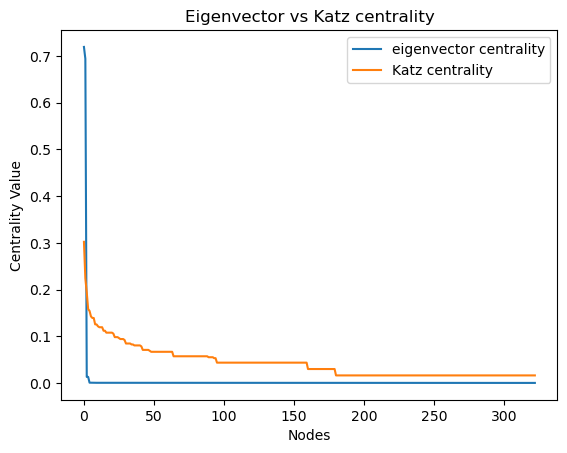

In [292]:
ev_centrality_list=sorted(ev_centrality.items(),key=lambda item:item[1],reverse=True)
ev_node, ev_value = zip(*ev_centrality_list)
ev_pos = np.arange(len(ev_node))

katz_centrality_list = sorted(katz_centrality.items(),key=lambda item:item[1],reverse=True)
k_node, k_value = zip(*katz_centrality_list)
k_pos = np.arange(len(k_node))

plt.plot(ev_pos,ev_value,"-", label = "eigenvector centrality")
plt.plot(k_pos,k_value,"-", label="Katz centrality")

plt.xlabel("Nodes")
plt.ylabel("Centrality Value")
plt.title("Eigenvector vs Katz centrality")
plt.legend()
plt.show()

# Misure: Network

In [293]:
{k:v for k,v in sorted(G.degree, key= lambda item:item[1], reverse=True)}

{'Snake': 27,
 'Leopard': 25,
 'Human': 23,
 'Bird': 22,
 'Orca': 18,
 'Lion': 17,
 'Fox': 17,
 'Crocodile': 16,
 'Tiger': 14,
 'Jaguar': 14,
 'Shark': 14,
 'Common Snapping Turtle': 13,
 'Wolf': 13,
 'Hyena': 13,
 'Owl': 11,
 'Hawk': 11,
 'Eagle': 11,
 'Bird of Prey': 10,
 'Yellow-Eyed Penguin': 9,
 'Cheetah': 8,
 'Kangaroo Rat': 8,
 'Bald Eagle': 7,
 'Dingo': 7,
 'Hummingbird': 7,
 'Praying Mantis': 7,
 'Star-Nosed Mole': 7,
 'Tufted Puffin': 7,
 'Cat': 7,
 'Fossa': 6,
 'Galápagos Penguin': 6,
 'Lyrebird': 6,
 'Platypus': 6,
 'Toco Toucan': 6,
 'Larger Fish': 6,
 'Alpine Ibex': 5,
 'Arctic Fox': 5,
 'Blue Jay': 5,
 'Bornean Orangutan': 5,
 'Echidna': 5,
 'Emperor Tamarin': 5,
 'Gerenuk': 5,
 'Giant Panda': 5,
 'Gila Monster': 5,
 'Green Anaconda': 5,
 "Grevy's Zebra": 5,
 'Pangolin': 5,
 'Polar Bear': 5,
 'Pronghorn': 5,
 'Snow Leopard': 5,
 'Sumatran Orangutan': 5,
 'Warthog': 5,
 'Wildebeest': 5,
 'Wombat': 5,
 'Fish': 5,
 'Python': 5,
 'African Wild Dog': 4,
 'Bottlenose Dolphin':

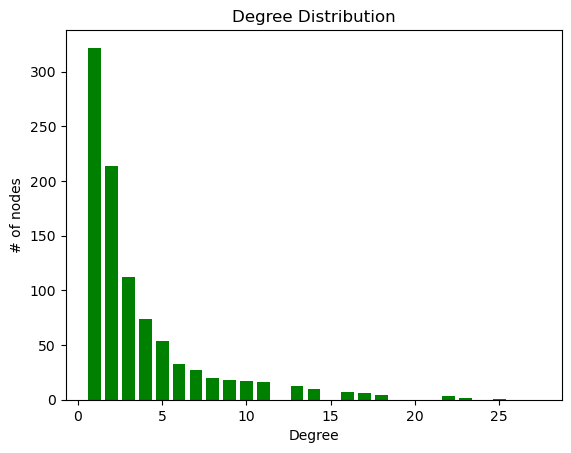

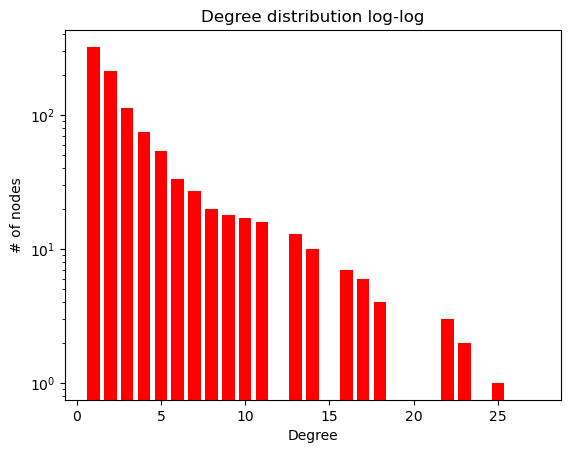

In [294]:
degree_sequence = list(G.degree)

degree_sequence.sort(key=lambda item:item[1],reverse=True)

nodes, degree = zip(*degree_sequence)

pos = np.arange(len(nodes))
width = 0.75

ax = plt.axes()
ax.set_title("Degree Distribution")
ax.set_xlabel("Degree")
ax.set_ylabel("# of nodes")
plt.bar(degree,pos,width,color='g')

plt.show()

# log-log scale
ax = plt.axes()
ax.set_title("Degree distribution log-log")
ax.set_xlabel("Degree")
ax.set_ylabel("# of nodes")
plt.bar(degree,pos,width,color='r', log=True)
plt.show()

Powerlaw calculation

In [295]:
result = powerlaw.Fit(degree)
print("alpha:",result.alpha)
print("xmin:",result.xmin)
print("p-value :",result.D)

Calculating best minimal value for power law fit
alpha: 3.0021906998907535
xmin: 4.0
p-value : 0.09472797711149328


## Simulazione estinzione

In [296]:
#Simulazione estinzione:
#                       -Maggiore grado entrante
#                       -Betweeness centrality maggiore --> Vedere quello che potrebbe creare un magiore impatto (positivo e negativo)
#                       -Tutti quelli critically endengered

#Per valutare gli effetti delle estinzioni possiamo:
#                       -Osservare come è cambiato la rete
#                       -Riapplicare le varie misurazioni e confrontarle con quelle precedenti per vedere chi ha subito maggiormente
#                       --> per esempio la connectance o il edge-to-node ratio
G_in_degree = G.copy()
G_betweenness = G.copy()
G_conservation_status = G.copy()

# Rete senza animali con grado entrante maggiore e quelli presenti nelle sottoreti

In [297]:
def deleteNodesWithHightInDegree(G):
    # Calcola il grado in ingresso di ciascun nodo e convertilo in un dizionario
    in_degrees = dict(G.in_degree())
    
    # Identifica i nodi con grado in ingresso maggiore o uguale a 6
    nodes_to_remove = [node for node, degree in in_degrees.items() if degree >= 6]
    
    # Memorizza i nodi eliminati insieme ai loro archi associati
    removed_nodes_and_edges = []
    for node in nodes_to_remove:
        removed_edges = list(G.in_edges(node))
        removed_nodes_and_edges.append((node, removed_edges))
    
    # Rimuovi i nodi e i relativi archi associati
    G.remove_nodes_from(nodes_to_remove)
    
    # Visualizza i nodi eliminati insieme ai loro archi associati
    print("Nodi eliminati e archi associati:")
    for node, edges in removed_nodes_and_edges:
        print(f"Nodo: {node}, Archi: {edges}")

def remove_node_from_graph(node_name, G):
    if node_name in G.nodes():
        G.remove_node(node_name)
        print(f"Il nodo {node_name} è stato rimosso dal grafo.")
    else:
        print(f"Il nodo {node_name} non esiste nel grafo.")

In [298]:
deleteNodesWithHightInDegree(G_in_degree)

Nodi eliminati e archi associati:
Nodo: Common Snapping Turtle, Archi: [('Fox', 'Common Snapping Turtle'), ('Fish', 'Common Snapping Turtle'), ('Owl', 'Common Snapping Turtle'), ('Raccoon', 'Common Snapping Turtle'), ('Crow', 'Common Snapping Turtle'), ('Hawk', 'Common Snapping Turtle'), ('Snake', 'Common Snapping Turtle'), ('Coyote', 'Common Snapping Turtle'), ('Skunk', 'Common Snapping Turtle'), ('Mink', 'Common Snapping Turtle'), ('Fisher', 'Common Snapping Turtle'), ('Heron', 'Common Snapping Turtle'), ('Bullfrog', 'Common Snapping Turtle')]
Nodo: Galápagos Penguin, Archi: [('Bird', 'Galápagos Penguin'), ('Shark', 'Galápagos Penguin'), ('Owl', 'Galápagos Penguin'), ('Hawk', 'Galápagos Penguin'), ('Snake', 'Galápagos Penguin'), ('Sea Lion', 'Galápagos Penguin')]
Nodo: Hummingbird, Archi: [('Blue Jay', 'Hummingbird'), ('Owl', 'Hummingbird'), ('Heron', 'Hummingbird'), ('Grackle', 'Hummingbird'), ('Tanager', 'Hummingbird'), ('Loggerhead Shrike', 'Hummingbird'), ('Gull', 'Hummingbird')]

In [299]:
remove_node_from_graph('Amazon Rainforest Frog', G_in_degree)
remove_node_from_graph('Galápagos Tortoise', G_in_degree)
remove_node_from_graph('Asian Elephant', G_in_degree)
remove_node_from_graph('Galliformes', G_in_degree)
remove_node_from_graph('Hagfish', G_in_degree)
remove_node_from_graph('Shortfin Mako Shark', G_in_degree)

Il nodo Amazon Rainforest Frog è stato rimosso dal grafo.
Il nodo Galápagos Tortoise è stato rimosso dal grafo.
Il nodo Asian Elephant è stato rimosso dal grafo.
Il nodo Galliformes è stato rimosso dal grafo.
Il nodo Hagfish è stato rimosso dal grafo.
Il nodo Shortfin Mako Shark è stato rimosso dal grafo.


In [300]:
nx.write_gexf(G_in_degree, 'estinzione_in_degree.gexf')

In [301]:
total_edges_after_extintion1 = G_in_degree.number_of_edges()
edges_losts = total_edges - total_edges_after_extintion1
print("Number of edges before: ", total_edges)
print("Number of edges new: ", total_edges_after_extintion1)
print("Number of edges losts: ", edges_losts)

Number of edges before:  505
Number of edges new:  417
Number of edges losts:  88


In [302]:
[total_nodes_after_extintion1, total_edges_after_extintion1, connectance_G_in_degree, edge_to_node_ratio_G_in_degree] = get_connectance_and_ratio(G_in_degree)
x = connectance_G - connectance_G_in_degree
x

Numero totale di nodi nel grafo: 306
Numero totale di archi nel grafo: 417
Connectance: 0.004453415353069332
Edge-to-Node-Ratio: 1.3627450980392157


0.00038704127931476085

# Rete senza i primi 10 animali con betweenness centrality maggiore

In [303]:
removed_edges_per_node = {}

# Itera attraverso i nodi rimossi
for node in top_10_bc_nodes:
    # Rimuovi il nodo dal grafo temporaneamente
    temp_graph = G_betweenness.copy()
    temp_graph.remove_node(node)
    
    # Trova gli archi rimossi
    removed_edges = []
    for edge in G_betweenness.edges(node):
        if not temp_graph.has_edge(*edge):
            removed_edges.append(edge)
    
    # Aggiungi gli archi rimossi al dizionario
    removed_edges_per_node[node] = removed_edges

# Stampare gli archi rimossi per ciascun nodo
for node, removed_edges in removed_edges_per_node.items():
    print(f"Archi rimossi per il nodo {node}:")
    for edge in removed_edges:
        print(edge)
G_betweenness.remove_nodes_from(top_10_bc_nodes)

Archi rimossi per il nodo Wolf:
('Wolf', 'Alpine Ibex')
('Wolf', 'American Bison')
('Wolf', 'Arctic Fox')
('Wolf', 'Bengal Fox')
('Wolf', 'Brown Bear')
('Wolf', 'Pronghorn')
('Wolf', 'Red Fox')
('Wolf', 'Snowy Owl')
('Wolf', 'Wild Boar')
('Wolf', 'Wolverine')
('Wolf', 'Yak')
Archi rimossi per il nodo Tiger:
('Tiger', 'Asian Elephant')
('Tiger', 'Gaur')
('Tiger', 'Gharial')
('Tiger', 'Lion-tailed Macaque')
('Tiger', 'Orangutan')
('Tiger', 'Pangolin')
('Tiger', 'Saola')
('Tiger', 'Sumatran Orangutan')
('Tiger', 'Sumatran Rhino')
('Tiger', 'Sumatran Rhinoceros')
('Tiger', 'Sun Bear')
('Tiger', 'Water Buffalo')
Archi rimossi per il nodo Bald Eagle:
('Bald Eagle', 'Arctic Fox')
('Bald Eagle', 'Tufted Puffin')
Archi rimossi per il nodo Dingo:
('Dingo', 'Echidna')
('Dingo', 'Frilled Lizard')
('Dingo', 'Lyrebird')
('Dingo', 'Red Kangaroo')
('Dingo', 'Wombat')
Archi rimossi per il nodo Fossa:
('Fossa', 'Aye-Aye')
('Fossa', "Coquerel's Sifaka")
('Fossa', 'Indri')
('Fossa', 'Lemur')
Archi rimossi

In [304]:
total_edges_after_extintion2 = G_betweenness.number_of_edges()
edges_losts = total_edges - total_edges_after_extintion2
print("Number of edges before: ", total_edges)
print("Number of edges new: ", total_edges_after_extintion2)
print("Number of edges losts: ", edges_losts)

Number of edges before:  505
Number of edges new:  435
Number of edges losts:  70


In [305]:
[total_nodes_after_extintion2, total_edges_after_extintion2, connectance_G_betweenness, edge_to_node_ratio_G_betweenness] = get_connectance_and_ratio(G_betweenness)
x = connectance_G - connectance_G_betweenness
x

Numero totale di nodi nel grafo: 313
Numero totale di archi nel grafo: 435
Connectance: 0.004440180056956793
Edge-to-Node-Ratio: 1.389776357827476


0.0004002765754273002

In [306]:
nx.write_gexf(G_betweenness, 'estinzione_betweenness_centrality.gexf')

# Rete senza gli animali in stato di conservazione Endangered e Critically Endangered

In [307]:
# Seleziona solo le righe in cui la colonna "Conservation Status" ha valori 'Endangered' o 'Critically Endangered'
endangered_animals = df[(df['Conservation Status'] == 'Endangered') | (df['Conservation Status'] == 'Critically Endangered')]

# Ottieni la lista degli animali
endangered_animals_list = endangered_animals['Animal'].tolist()

In [308]:
def remove_endangered_nodes(graph):
    # Trova i nodi che hanno in 'conservation_status' i valori 'Endangered' o 'Critically Endangered'
    nodes_to_remove = [node for node, data in graph.nodes(data=True) if 'conservation_status' in data and 
                       data['conservation_status'] in ['Endangered', 'Critically Endangered']]
    
    # Rimuovi i nodi identificati
    graph.remove_nodes_from(nodes_to_remove)
    
    # Ritorna i nodi eliminati
    return nodes_to_remove

In [309]:
removed_nodes = remove_endangered_nodes(G_conservation_status)
print(removed_nodes)

['African Wild Dog', 'Asian Elephant', 'Axolotl', 'Aye-Aye', "Baird's Tapir", 'Barbary Macaque', 'Bengal Tiger', 'Black Rhinoceros', 'Blue Whale', 'Bonobo', 'Bornean Orangutan', 'Chimpanzee', 'Chinese Giant Salamander', "Coquerel's Sifaka", 'Eastern Gorilla', 'GalÃ¡pagos Penguin', 'Galápagos Penguin', 'Gharial', 'Giant Panda', 'Golden Lion Tamarin', 'Green Sea Turtle', "Grevy's Zebra", 'Iberian Lynx', 'Indri', 'Kakapo', 'Lemur', 'Lion-tailed Macaque', 'Mountain Gorilla', 'Numbat', 'Okapi', 'Orangutan', 'Pangolin', 'Proboscis Monkey', 'Red Panda', 'Saola', 'Sumatran Orangutan', 'Sumatran Rhino', 'Sumatran Rhinoceros', 'Sumatran Tiger', 'Tasmanian Devil', 'Tiger', 'Tree Kangaroo', 'Vaquita', 'Western Gorilla', 'Western Lowland Gorilla', 'White Tiger', 'Yellow-Eyed Penguin', 'Zebra Shark']


In [310]:
total_edges_after_extintion3 = G_conservation_status.number_of_edges()
edges_losts = total_edges - total_edges_after_extintion3
print("Number of edges before: ", total_edges)
print("Number of edges new: ", total_edges_after_extintion3)
print("Number of edges losts: ", edges_losts)

Number of edges before:  505
Number of edges new:  369
Number of edges losts:  136


In [311]:
[total_nodes_after_extintion3, total_edges_after_extintion3, connectance_G_conservation_status, edge_to_node_ratio_G_conservation_status] = get_connectance_and_ratio(G_conservation_status)
x = connectance_G - connectance_G_conservation_status
x

Numero totale di nodi nel grafo: 275
Numero totale di archi nel grafo: 369
Connectance: 0.0048793388429752066
Edge-to-Node-Ratio: 1.3418181818181818


-3.8882210591113624e-05

In [312]:
nx.write_gexf(G_conservation_status, 'estinzione_conservation_status.gexf')

In [313]:
def convert_to_undirected_graph(graph):
    undirected_graph = nx.Graph()  # Inizializza il grafo non orientato

    for node, neighbors in graph.adjacency():
        undirected_graph.add_node(node)  # Aggiungi il nodo al grafo non orientato
        for neighbor in neighbors:
            undirected_graph.add_edge(node, neighbor)  # Aggiungi il collegamento non diretto tra il nodo e il suo vicino

    return undirected_graph

In [314]:
G1 = G.copy()
G1_conservation_status = G_conservation_status.copy()
undirected_graph_G = convert_to_undirected_graph(G1)
undirected_graph_G_conservation_status = convert_to_undirected_graph(G1_conservation_status)
undirected_graph_G['Asian Elephant']

AtlasView({'Tiger': {}})

In [315]:
def archi_mancanti(grafo1, grafo2):
    archi_assenti = []
    for u, v in grafo1.edges():
        if not grafo2.has_edge(u, v):
            archi_assenti.append((u, v))
    return archi_assenti

In [316]:
archi_mancanti = archi_mancanti(undirected_graph_G, undirected_graph_G_conservation_status)

# Stampa gli archi mancanti
for u, v in archi_mancanti:
    print(f"Arco assente: ({u}, {v})")

Arco assente: (African Wild Dog, Gerenuk)
Arco assente: (African Wild Dog, Warthog)
Arco assente: (African Wild Dog, Lion)
Arco assente: (African Wild Dog, Hyena)
Arco assente: (Asian Elephant, Tiger)
Arco assente: (Axolotl, Bird)
Arco assente: (Axolotl, Fish)
Arco assente: (Aye-Aye, Fossa)
Arco assente: (Aye-Aye, Bird of Prey)
Arco assente: (Baird's Tapir, Crocodile)
Arco assente: (Baird's Tapir, Jaguar)
Arco assente: (Baird's Tapir, Puma)
Arco assente: (Barbary Macaque, Leopard)
Arco assente: (Barbary Macaque, Eagle)
Arco assente: (Barbary Macaque, Domestic Dog)
Arco assente: (Bengal Tiger, Crocodile)
Arco assente: (Bengal Tiger, Human)
Arco assente: (Black Rhinoceros, Lion)
Arco assente: (Black Rhinoceros, Hyena)
Arco assente: (Blue Whale, Orca)
Arco assente: (Bonobo, Leopard)
Arco assente: (Bonobo, Human)
Arco assente: (Bornean Orangutan, Leopard)
Arco assente: (Bornean Orangutan, Crocodile)
Arco assente: (Bornean Orangutan, Bearded Pig)
Arco assente: (Bornean Orangutan, Python)
Ar